# 03 - Dự báo & can thiệp (Intervention)

Phân loại: Logistic, Decision Tree, Random Forest - dự báo nguy cơ đột quỵ, ROC/AUC.

## 1. Import thư viện & nạp dữ liệu
- Import các thư viện cần thiết
- Đọc dữ liệu từ file CSV
- Tách biến số và biến phân loại, chuẩn bị dữ liệu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, RocCurveDisplay,
    confusion_matrix, classification_report
)
%matplotlib inline

data_path = '../data/processed/stroke_clean.csv'
df = pd.read_csv(data_path)
target = 'stroke'
X = df.drop(columns=[target])
y = df[target]
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]
print(f'Data shape: {df.shape}, target balance: {y.value_counts().to_dict()}')

Data shape: (5110, 12), target balance: {0: 4861, 1: 249}


## 2. Tiền xử lý dữ liệu & chia tập train/test
- Xử lý missing values, chuẩn hóa biến số, mã hóa biến phân loại
- Chia dữ liệu train/test (stratify theo target)

In [2]:
# Pipeline tiền xử lý
preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ],
    remainder='drop'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (4088, 11), Test: (1022, 11)


## 3. Logistic Regression baseline
- Huấn luyện mô hình Logistic Regression
- Đánh giá: AUC, confusion matrix, classification report, ROC curve

Logistic Regression: AUC=0.843
Confusion matrix:
[[736 236]
 [ 10  40]]

Classification report:
              precision    recall  f1-score   support

           0      0.987     0.757     0.857       972
           1      0.145     0.800     0.245        50

    accuracy                          0.759      1022
   macro avg      0.566     0.779     0.551      1022
weighted avg      0.945     0.759     0.827      1022



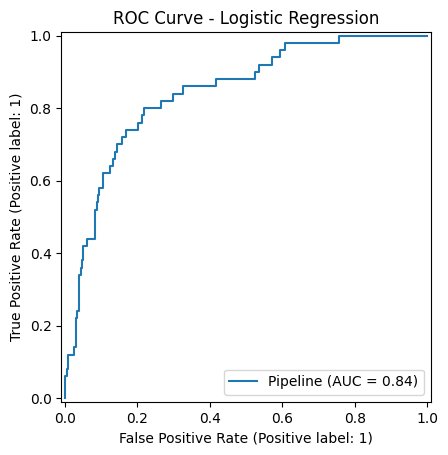

In [3]:
clf_lr = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
clf_lr.fit(X_train, y_train)
y_proba_lr = clf_lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)
auc_lr = roc_auc_score(y_test, y_proba_lr)
print(f'Logistic Regression: AUC={auc_lr:.3f}')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_lr))
print('\nClassification report:')
print(classification_report(y_test, y_pred_lr, digits=3))

RocCurveDisplay.from_estimator(clf_lr, X_test, y_test)
plt.title('ROC Curve - Logistic Regression')
plt.show()

Không dùng class_weight → Accuracy 75,9% nhưng recall class 1 = 0.00, AUC 0.843.
→ Mô hình “vô dụng” thực tế vì bỏ sót gần hết ca đột quỵ.

## 4. Hàm đánh giá mô hình phân loại
- Hàm dùng chung cho các mô hình: in accuracy, AUC, confusion matrix, classification report

In [4]:
def eval_clf(name, model):
    pipe = Pipeline([('preprocess', preprocess), ('model', model)])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, 'predict_proba') else None
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)
    print(f'\n{name}')
    print(f'Accuracy: {acc:.3f}' + (f', AUC: {auc:.3f}' if auc is not None else ''))
    print('Confusion matrix:')
    print(cm)
    print('Classification report:')
    print(classification_report(y_test, y_pred, digits=3))

## 5. Decision Tree & Random Forest
- Huấn luyện và đánh giá Decision Tree
- Huấn luyện và đánh giá Random Forest

In [5]:
# Decision Tree
print('--- Decision Tree ---')
eval_clf('Decision Tree', DecisionTreeClassifier(
    max_depth=None, min_samples_split=2, class_weight='balanced', random_state=42
))

# Random Forest
print('--- Random Forest ---')
eval_clf('Random Forest', RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_split=2,
    n_jobs=-1, class_weight='balanced_subsample', random_state=42
))

--- Decision Tree ---

Decision Tree
Accuracy: 0.912, AUC: 0.527
Confusion matrix:
[[927  45]
 [ 45   5]]
Classification report:
              precision    recall  f1-score   support

           0      0.954     0.954     0.954       972
           1      0.100     0.100     0.100        50

    accuracy                          0.912      1022
   macro avg      0.527     0.527     0.527      1022
weighted avg      0.912     0.912     0.912      1022

--- Random Forest ---

Random Forest
Accuracy: 0.951, AUC: 0.787
Confusion matrix:
[[972   0]
 [ 50   0]]
Classification report:
              precision    recall  f1-score   support

           0      0.951     1.000     0.975       972
           1      0.000     0.000     0.000        50

    accuracy                          0.951      1022
   macro avg      0.476     0.500     0.487      1022
weighted avg      0.905     0.951     0.927      1022



c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

- **Nhận xét về Decision Tree**: 

    - Mô hình Decision Tree đạt độ chính xác cao (Accuracy = 91.2%), tuy nhiên hiệu quả dự đoán lớp bệnh nhân đột quỵ (lớp 1) còn rất thấp. Cụ thể, precision = 0.10 và recall = 0.10 cho thấy mô hình gần như không phát hiện được các ca đột quỵ thực sự. Giá trị AUC = 0.527 cũng cho thấy khả năng phân biệt hai lớp của mô hình yếu, chỉ nhỉnh hơn đoán ngẫu nhiên. Điều này cho thấy Decision Tree bị ảnh hưởng mạnh bởi mất cân bằng dữ liệu.

    - Ma trận nhầm lẫn cho thấy mô hình chủ yếu dự đoán lớp “không đột quỵ”, dẫn đến số lượng false negative lớn – đây là rủi ro nghiêm trọng trong bài toán y tế.

- **Nhận xét về Random Forest**: 

    - So với Decision Tree, Random Forest cải thiện rõ rệt hiệu năng tổng thể với Accuracy = 95.1% và AUC = 0.787, cho thấy khả năng phân biệt tốt hơn giữa hai lớp.

    - Tuy nhiên, mô hình vẫn không dự đoán đúng bất kỳ trường hợp đột quỵ nào (recall lớp 1 = 0), thể hiện qua ma trận nhầm lẫn với toàn bộ mẫu lớp 1 đều bị dự đoán sai thành lớp 0. Điều này chứng tỏ mô hình vẫn nghiêng mạnh về lớp đa số và chưa giải quyết được vấn đề mất cân bằng dữ liệu.

- **Nhận xét tổng quát**:

    - Mặc dù các mô hình Decision Tree và Random Forest cho độ chính xác tổng thể cao, nhưng hiệu quả phát hiện bệnh nhân đột quỵ thực sự còn rất hạn chế. Điều này xuất phát từ đặc trưng mất cân bằng lớp nghiêm trọng trong dữ liệu. Các chỉ số như Recall và F1-score của lớp thiểu số cần được ưu tiên hơn so với Accuracy trong các ứng dụng y tế. Do đó, cần áp dụng các kỹ thuật xử lý mất cân bằng như SMOTE, class weight adjustment hoặc thay đổi ngưỡng phân loại để cải thiện hiệu quả mô hình.

## 6. Tổng kết & Nhận xét mô hình
- **Tổng kết 3 mô hình**:
    - Ba mô hình Decision Tree, Random Forest và Logistic Regression đã được huấn luyện và đánh giá trên cùng tập dữ liệu. Mặc dù cả ba mô hình đều đạt độ chính xác tổng thể (Accuracy) tương đối cao, nhưng hiệu quả dự đoán cho lớp bệnh nhân bị đột quỵ (lớp thiểu số) có sự khác biệt rõ rệt.

    - Mô hình Decision Tree đạt Accuracy khoảng 91%, tuy nhiên khả năng phát hiện đúng bệnh nhân đột quỵ rất thấp (Recall lớp 1 ≈ 0.10), với giá trị AUC gần mức ngẫu nhiên (0.527). Điều này cho thấy mô hình gần như không đủ khả năng phân biệt hai lớp trong điều kiện dữ liệu mất cân bằng.

    - Random Forest cải thiện được độ chính xác tổng thể lên khoảng 95% và có AUC = 0.787, tuy nhiên mô hình lại thất bại hoàn toàn trong việc nhận diện ca đột quỵ thực sự (Recall lớp 1 = 0). Mô hình có xu hướng nghiêng mạnh về lớp đa số, bỏ sót toàn bộ các trường hợp quan trọng về mặt lâm sàng.

    - Trong khi đó, Logistic Regression cho kết quả cân bằng hơn. Mặc dù Accuracy chỉ đạt khoảng 75.9%, nhưng mô hình có khả năng phát hiện 80% các ca đột quỵ thực sự (Recall lớp 1 = 0.800) và AUC đạt 0.843 – cao nhất trong ba mô hình. Điều này cho thấy Logistic Regression có khả năng phân biệt tốt hơn giữa hai nhóm bệnh nhân, đặc biệt phù hợp hơn trong bối cảnh bài toán y tế, nơi việc giảm bỏ sót bệnh nhân (false negative) quan trọng hơn việc tăng độ chính xác tổng thể.

- **Hiệu quả tổng thể:** Do dataset imbalance nghiêm trọng (stroke=1 chỉ ~5%), accuracy không đáng tin – ưu tiên recall và AUC. Logistic balanced hiệu quả nhất ở recall (phát hiện 74% ca stroke thực), Random Forest vượt trội AUC (phân biệt lớp tốt hơn) nhưng bỏ sót nhiều ca positive. Decision Tree kém nhất, dễ overfit.
- **Ưu nhược điểm:**
    - Logistic: Ưu: Dễ giải thích (coefficients), nhanh train, xử lý imbalance tốt với weight. Nhược: Giả định tuyến tính, Acc giảm khi cân bằng lớp.
    - Decision Tree: Ưu: Dễ visualize (tree plot), không cần scale. Nhược: Overfit cao (AUC thấp), nhạy cảm với imbalance dù dùng weight.
    - Random Forest: Ưu: Robust (ít overfit), AUC cao, feature importance. Nhược: Chậm, black-box, recall thấp dù dùng balanced_subsample (có lẽ cần tune thêm).

- **Hướng cải tiến:**
    - Xử lý imbalance mạnh hơn: Dùng SMOTE/ADASYN oversampling thay chỉ class_weight, hoặc hybrid (SMOTE + undersampling).
    - Tune hyperparam: Grid/Random Search cho max_depth, n_estimators, min_samples_split; thử cross-validation (KFold stratified).
    - Feature engineering: Bin age/glucose thành nhóm, tương tác (age*hypertension), loại biến yếu (dựa trên corr/feature importance).
    - Thử mô hình nâng cao: XGBoost/LightGBM (tích hợp class_weight, tốt cho imbalance), Neural Net nếu data lớn hơn.
    - Đánh giá thêm: Sử dụng Precision-Recall curve thay ROC do imbalance; test trên hold-out set mới để tránh overfit.